# This was my first attempt at building a neural network from scratch

In this notebook I build a generic neural network and use it to predict daily bike rental ridership. 
The notebook was developed using the starter code from [Udacity Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101). 
I added the following:   
* Added code to make the ```TheNeuralNetwork Class``` capable of handling multiple layers 
 


In [1]:
#TODO: enable network to work with different data sets, i.e. make sure inputs conform to number of nodes in input

#TODO: Change testing framework to work with multilayer network  
#TODO: Add THINGS that I added to notebook 

In [2]:
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import os
import requests, zipfile, io


## Download the data set and save it in the data folder 
We use the annotated dataset from *Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.* 

The dataset can be downloaded from the website of the [UC-Irvine Machine Learning  group]('https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip') 



In [3]:
#check if data folder exists, if it does not create folder and get data set
path = os.getcwd() + '/Data'

if not os.path.exists(path):
    os.makedirs(path)
    
    data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
    r = requests.get(data_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path)
    
else:
    print('Data set exists in: ' + path)

Data set exists in: /Users/ricardojimenezmartinez/Desktop/DLND-project1-your-first-network/Data


## Load the data
We load the data from disk. The dataset is provided with a `Readme` file describing the dataset characteristics. 

In [4]:
data_path = 'Data/hour.csv'
rides = pd.read_csv(data_path) 

show_readme = False

if show_readme:
    !cat Data/Readme.txt


In [5]:
print('Data set fields:', rides.columns.tolist() )


Data set fields: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


## Prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [6]:
data_path = 'Data/hour.csv'
rides = pd.read_csv(data_path)

In [7]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

<AxesSubplot:xlabel='hr', ylabel='[registered]'>

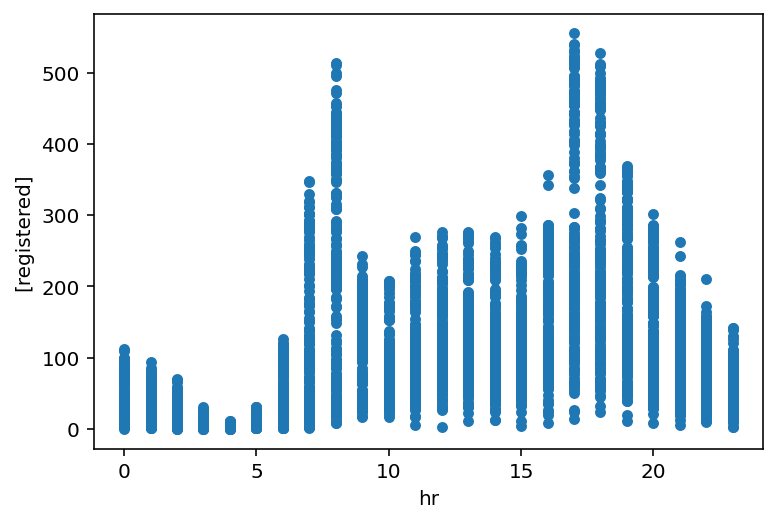

In [8]:
rides[24*10:24*200].plot.scatter(x='hr', y=['registered'])
# rides[:24*10].plot(x='dteday', y='registered')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [9]:
data2process =  rides
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(data2process[each], prefix=each, drop_first=False)
    data2process = pd.concat([data2process, dummies], axis=1)

fields_to_drop = ['season', 'weathersit', 'mnth','hr','weekday',
                  'instant', 'dteday', 'atemp',  'workingday']

data = data2process.drop(fields_to_drop, axis=1)
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [10]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [11]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [12]:
x = features.to_numpy()
y = targets.to_numpy()[:,0]

training_data = [(x,y)]

x = test_features.to_numpy()
y = test_targets.to_numpy()[:,0]

test_data = [(x,y)]


In [13]:
test_targets.columns

Index(['cnt', 'casual', 'registered'], dtype='object')

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [14]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

# The neural Network 

In [93]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def MSE(y, Y):
    return np.mean((y-Y)**2)

class TheNeuralNetwork(object):
    def __init__(self, network_architecture, learning_rate):
        # Initialize object using network architecture 
        # 
        self.num_layers = len(network_architecture)
        self.network_architecture = network_architecture
        
        # Initialize weights and biases       
        self.biases = [ np.random.randn(number_neurons, 1) for number_neurons in network_architecture[1:]]  
        
        self.weights = [np.random.normal(0.0, num_rows**-0.5, (num_rows, num_cols))
                        for num_cols, num_rows in zip(network_architecture[:-1], network_architecture[1:])]
        
        self.learning_rate = learning_rate
        
        # Activation function is the sigmoid function
        self.activation_function = sigmoid 
    
    def feedforward(self, input_to_network):
        """Return activations, and w*activations vector for all layers if a is an input"""
         
        activation = input_to_network
        activations = [activation] # list to store all the activations, layer by layer
        zs = [] # list to store all the weighted inputs to  layers, layer by layer
        
        for b, w in zip(self.biases,self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        return activations, zs
    
    def train(self, inputs_list, targets_list):
             
        x = np.array(inputs_list, ndmin  = 2).T
        y = np.array(targets_list, ndmin = 2).T
        
        # assert x, y have the right shape 
        if x.shape[0] != self.network_architecture[0]:
            raise ValueError(f'Length of input predictors {x.shape[0]} do not match number of inputs in network architecture {self.network_architecture[0]}')
        
        if y.shape[0] != self.network_architecture[-1]:
            raise ValueError(f'''Length of targets {y.shape[0]} do not match number of number of outputs
                             in network architecture {self.network_architecture[-1]}''')
        
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activations, zs = self.feedforward(x)
        y_hat = zs[-1]
        
        # backward pass
        # gradient descent for weights matrix connecting second-last to output layers 
        delta = self.cost_derivative(y_hat, y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.outer(delta, activations[-2])
        
        # gradient descent for weights matrix in all inner layers 
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.outer(delta, activations[-l-1])
        
        self.weights = [w - self.learning_rate*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b- self.learning_rate*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        
        return (output_activations-y)
    
    def predict(self, inputs_list):
        # TODO: assert inputs have the right shape
        
        inputs = np.array(inputs_list, ndmin=2).T
        activation = inputs
        activations = [activation] # list to store all the activations, layer by layer
        zs = [] # list to store all the weighted inputs to  layers, layer by layer
        
        for b, w in  zip(self.biases, self.weights):
            z = np.dot(w, activation) +b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        network_output = activation
        
        return z[-1]
 

# Testing the network with the bike rental dataset

In [94]:
import sys

### Set the hyperparameters here ###
epochs = 700
learning_rate = 1
hidden_nodes = 25
output_nodes = 1

input_nodes = train_features.shape[1] 

network_architecture = [input_nodes, hidden_nodes, output_nodes]

network = TheNeuralNetwork(network_architecture, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.loc[batch].values, 
                              train_targets.loc[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.predict(train_features), train_targets['cnt'].values)
    val_loss   = MSE(network.predict(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.8% ... Training loss: 0.084 ... Validation loss: 0.155

(-0.03952530521971077, 0.5)

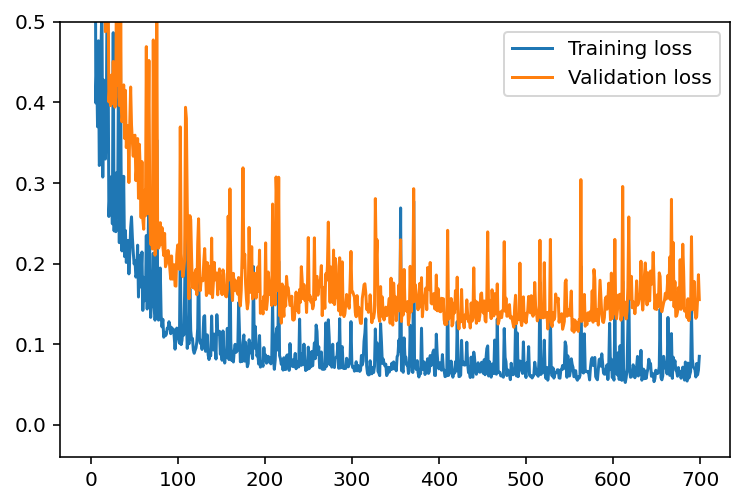

In [95]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

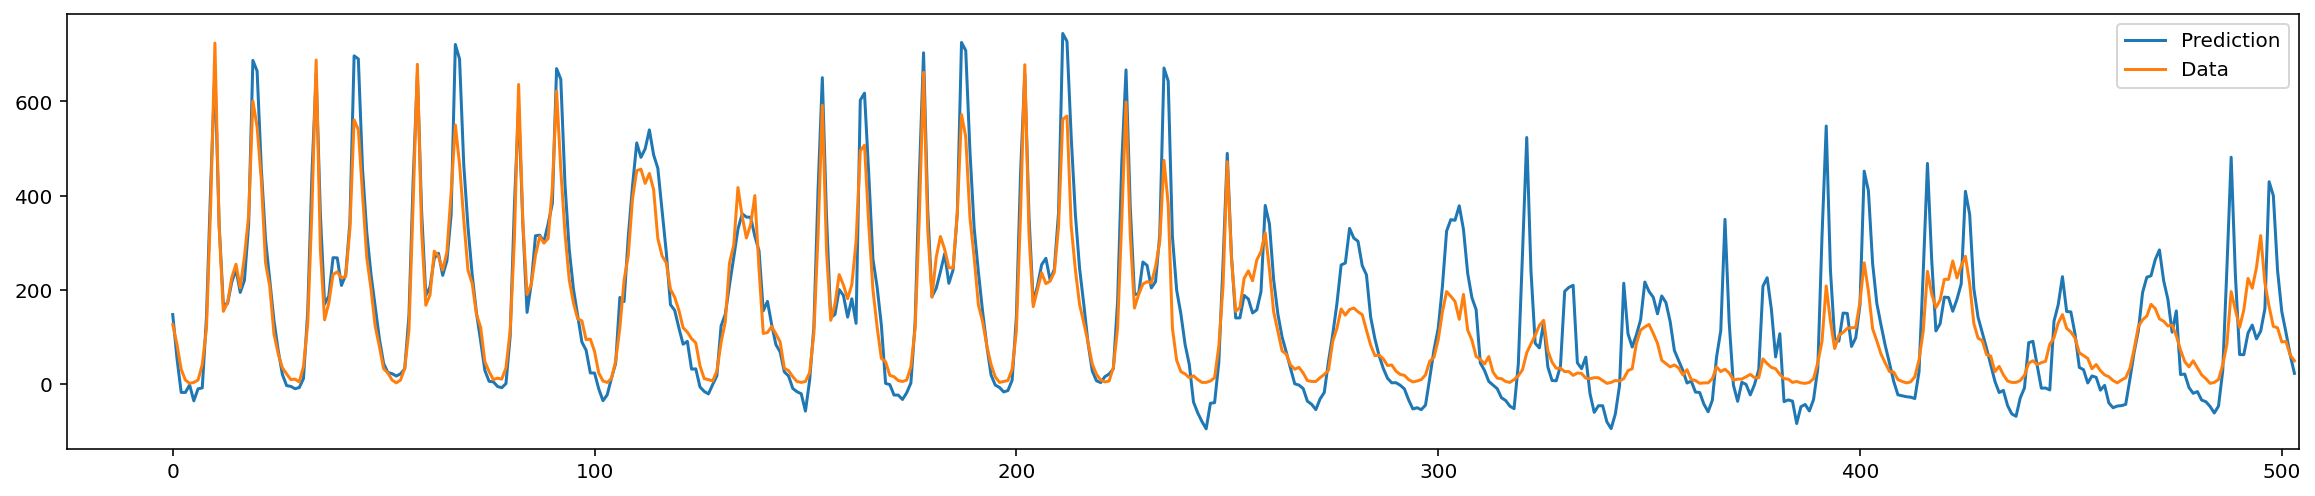

In [21]:
fig, ax = plt.subplots(figsize=(20,4))

mean, std = scaled_features['cnt']
predictions = network.predict(test_features)*std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

# dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
# dates = dates.apply(lambda d: d.strftime('%b %d'))
# ax.set_xticks(np.arange(len(dates))[12::24])
# _ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

The model predicts the data very well up to the last week of December where it starts to fail. It seems to me that this is a seasonal effect, i.e. holidays effect, for which there is not enough data to train the network.     

In [32]:
network.weights[1].shape

(1, 25)

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [90]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'data/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(data, pd.DataFrame))
    
#     ##########
#     # Unit tests for network functionality
#     ##########

    def test_activation(self):
        network = TheNeuralNetwork([3,2,1],0.08)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are initialized with correct shape
        network = TheNeuralNetwork([3, 2, 2], 0.5)
        
        
        self.assertTrue(np.allclose(network.weights[1].shape, 
                                    (2,2)))
        
        self.assertTrue(np.allclose(network.weights[0].shape, 
                                    (2,3)))

#     def test_run(self):
#         # Test correctness of run method
#         network = TheNeuralNetwork([3, 2, 1], 0.08)
#         network.weights[0] = test_w_i_h.copy()
#         network.weights[1] = test_w_h_o.copy()

#         self.assertTrue(np.allclose(network.predict(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [ ]:
## From starter notebook

In [112]:
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def MSE(y, Y):
#     return np.mean((y-Y)**2)

# class NeuralNetwork(object):
#     def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
#         # Set number of nodes in input, hidden and output layers.
#         self.input_nodes = input_nodes
#         self.hidden_nodes = hidden_nodes
#         self.output_nodes = output_nodes

#         # Initialize weights
#         self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
#                                        (self.hidden_nodes, self.input_nodes))

#         self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
#                                        (self.output_nodes, self.hidden_nodes))
#         self.lr = learning_rate
        
#         #### Set this to your implemented sigmoid function ####
#         # Activation function is the sigmoid function
#         self.activation_function = sigmoid 
    
#     def train(self, inputs_list, targets_list):
#         # Convert inputs list to 2d array
#         inputs = np.array(inputs_list, ndmin=2).T
#         targets = np.array(targets_list, ndmin=2).T
        
#         #### Implement the forward pass here ####
#         ### Forward pass ###
#         # TODO: Hidden layer
# #         hidden_inputs = inputs # signals into hidden layer
# #         hidden_outputs = self.activation_function(np.dot(self.weights_input_to_hidden,inputs))# signals from hidden layer
        
#         hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
#         hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
#         # TODO: Output layer
# #         final_inputs  = hidden_outputs  # signals into final output layer
# #         final_outputs = np.dot(self.weights_hidden_to_output,hidden_outputs)  # signals from final output layer
        
#         final_inputs  = np.dot(self.weights_hidden_to_output,hidden_outputs)  # signals into final output layer
#         final_outputs = final_inputs  # signals from final output layer
        
#         #### Implement the backward pass here ####
#         ### Backward pass ###
        
#         # TODO: Output error
#         output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        
#         # TODO: Backpropagated error
#         hidden_errors = output_errors*self.weights_hidden_to_output.T # errors propagated to the hidden layer
#         hidden_grad   = hidden_outputs*(1-hidden_outputs)# hidden layer gradients
        
#         # TODO: Update the weights
#         self.weights_hidden_to_output += self.lr*output_errors*hidden_outputs.T# update hidden-to-output weights with gradient descent step
#         self.weights_input_to_hidden += self.lr*hidden_errors*hidden_grad*inputs.T# update input-to-hidden weights with gradient descent s
        
    
#     def run(self, inputs_list):
#         # Run a forward pass through the network
#         inputs = np.array(inputs_list, ndmin=2).T
        
#         #### Implement the forward pass here ####
#         # TODO: Hidden layer
#         hidden_inputs = inputs# signals into hidden layer
#         hidden_outputs = self.activation_function(np.dot(self.weights_input_to_hidden,inputs))# signals from hidden layer
        
#         # TODO: Output layer
#         final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)# signals into final output layer
#         final_outputs = final_inputs # signals from final output layer 
        
#         return final_outputs

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [184]:
# import sys

# ### Set the hyperparameters here ###
# epochs = 700
# learning_rate = 0.1
# hidden_nodes  = 50
# output_nodes  = 1

# N_i = train_features.shape[1]
# network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

# losses = {'train':[], 'validation':[]}
# for e in range(epochs):
#     # Go through a random batch of 128 records from the training data set
#     batch = np.random.choice(train_features.index, size=128)
#     for record, target in zip(train_features.loc[batch].values, 
#                               train_targets.loc[batch]['cnt']):
#         network.train(record, target)
    
#     # Printing out the training progress
#     train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
#     val_loss   = MSE(network.run(val_features), val_targets['cnt'].values)
#     sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
#                      + "% ... Training loss: " + str(train_loss)[:5] \
#                      + " ... Validation loss: " + str(val_loss)[:5])
    
#     losses['train'].append(train_loss)
#     losses['validation'].append(val_loss)

Progress: 99.8% ... Training loss: 0.061 ... Validation loss: 0.146